### SARIMA Modelling

A SARIMA Model stands for [Seasonal, Auto Regressive, Integrated, Moving Average] model. We will try to fit the same while considering Walmart's quarterly sales data for the period 2003-2015 for the task. Our objectives will be:
- A) Initial data exploration
- B) Fitting an ARIMA Model
- C) Testing the Model on a test set
- D) Forecasting for next four quarters (*i.e 1 year ahead*)

In [1]:
# Importing all the necessary libraries

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
ts = pd.read_csv('E:/Projects/R Workspace/ARIMA_Modelling/Walmart_2.csv') # Importing the data

In [3]:
# Some pre-process cleaning
ts.drop(['Year', 'Quarter', 'GDP', 'L1_GDP','L4_GDP', 'L1_Sales', 'L4_Sales'], axis=1, inplace=True)
time_index = pd.date_range('2003-01-01', periods=len(ts), freq='Q')
ts.index = time_index
ts.columns = ["Sales ($ billion)"]

### A) Initial data exploration

##### We are presented by Walmart's quarterly sales ($ billion). It is evident that an upward trend and strong seasonality is present in the series, implying the series is Non-stationary. It also looks like the trend is getting damped 2011-Q3, as shown in figure below.

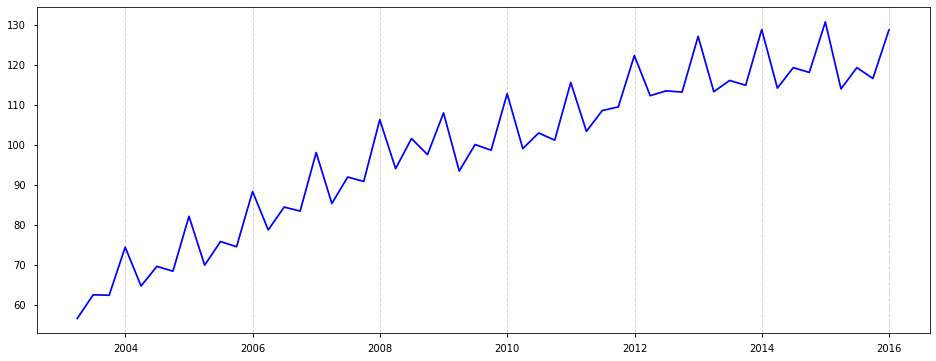

In [4]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(16,6))
plt.plot(ts, color='b')
plt.grid(b=True,axis='x', linestyle='--',  color='#D3D3D3')
plt.show()

In [5]:
# Handy function to generate plots quickly

def plot_it(data, label= ""):
    plt.figure(figsize=(15,5))
    plt.plot(data)
    plt.grid(b=True,axis='x', linestyle='--')
    plt.ylabel(label, fontsize=12)
    plt.xlabel('Time')

Firstly, we will do Seasonal Differencing that will remove the seasonality from the data. (*$X_{t}$ - $X_{m}$, m = season*)

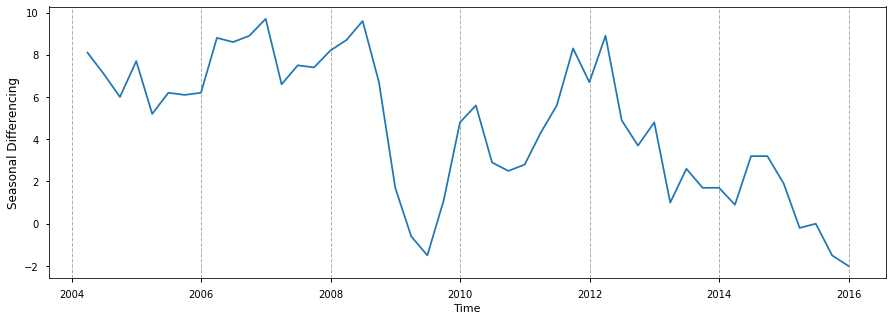

In [6]:
seasonal_diff = ts.diff(4)[4:]
plot_it(seasonal_diff, "Seasonal Differencing")
plt.show()

Next, we take first difference of the seasonally differenced series inorder to detrend it.

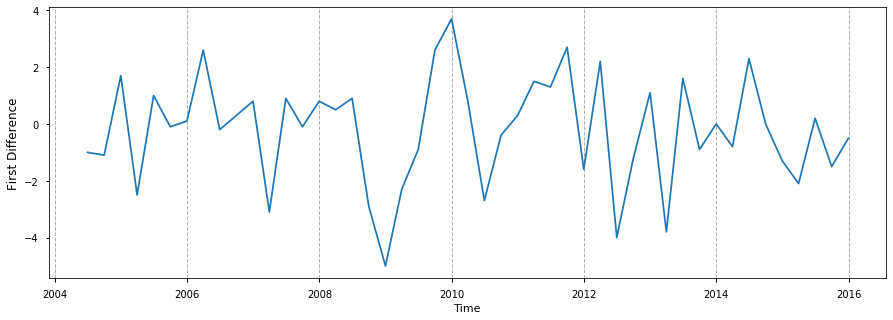

In [7]:
first_diff = seasonal_diff.diff()[1:]
plot_it(first_diff, "First Difference")
plt.show()

The series is now looking Stationary. We can run an ADF test on the resulting series to testify the same.

In [8]:
result = adfuller(first_diff)
print("ADF test statistic =", result[0])
print("pValue =", result[1])

ADF test statistic = -5.364402079560006
pValue = 4.021867400837077e-06


The ADF pValue is smaller than tabulated pValue (0.05). We can reject the Null hypothesis and accept that series is now Stationary.

In [9]:
# Handy function to plot ACF and PACF quickly
def cf_plots(ts):
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    plot_acf(ts, lags = 20, alpha=0.05, ax=axes[0])
    plot_pacf(ts, lags = 20, alpha=0.05, ax=axes[1])

Now that we have claimed the time series is Stationary, we can plot ACF and PACF in order to find number of terms for the ARIMA model.

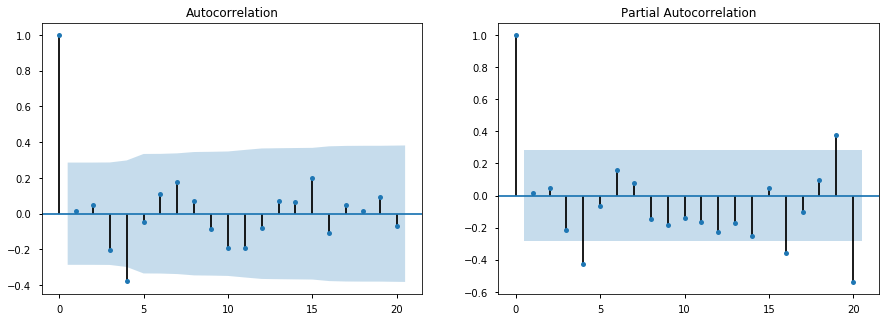

In [10]:
cf_plots(first_diff)
plt.show()

- There's only 1 non-seasonal significant spike in the PACF plot (at Lag 19)
- It is evident that there are significant spikes at seasonal lags in PACF plot and one in ACF plot (at Lag 4)

We can start our analysis by including:

- 1 non-seasonal AR term $\implies$ p = 1
- 2 non-seasonal MA term, since we noticed a damped trend effect$\implies$ q = 2
- 1 seasonal AR terms$\implies$ P = 1

- Non seasonal differencing once$\implies$ d = 1
- Seasonal differencing once$\implies$ D = 1
- Quarterly Data$\implies$ s = 4

### B)  After splitting the data for training and testing purposes, we start fitting the ARIMA model based on our findings.

In [11]:
train_period = datetime(2012,3,31)
test_period = datetime(2012,6,30)
train_ts = ts[:train_period]
test_ts = ts[test_period:]

In [12]:
final_order = (1,1,2) # order (p,d,q)
final_seasonal_order = (1,1,0,4) # order (P,D,Q,s)
model = ARIMA(train_ts, order=final_order, seasonal_order=final_seasonal_order) # Initializing the Model
fit_model = model.fit() # Fitting the Model

print(fit_model.summary()) # Summary of the Model

                                    SARIMAX Results                                     
Dep. Variable:                Sales ($ billion)   No. Observations:                   37
Model:             ARIMA(1, 1, 2)x(1, 1, [], 4)   Log Likelihood                 -62.283
Date:                          Fri, 31 Jul 2020   AIC                            134.567
Time:                                  11:39:31   BIC                            141.895
Sample:                              03-31-2003   HQIC                           136.996
                                   - 03-31-2012                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8951      0.338     -2.651      0.008      -1.557      -0.233
ma.L1          0.9901      0.466      2.127      0.

Inferences from the Fitted Model
- Except for a MA term co-efficient at Lag 2, all other co-efficients are statistically significant.
- pValue for Ljung-Box statistic (*Prob(Q) = 0.82*) is greater than 0.05. We can claim that data is not significantly different from white noise.
- Heteroskedasticity could be an issues for the model. Same could be treated later with an ARCH or GARCH model.

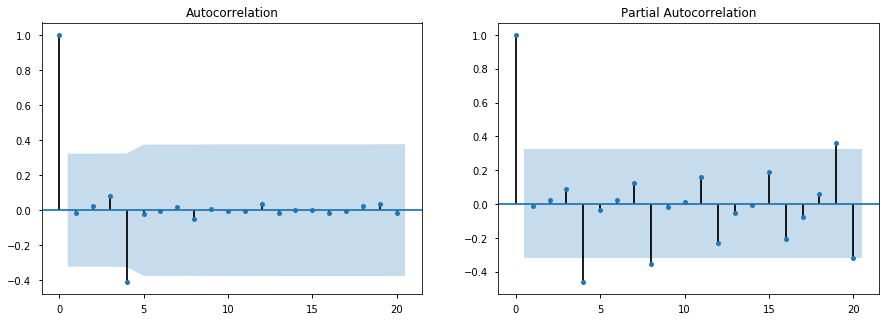

In [13]:
# Residual analysis

residuals = fit_model.resid
cf_plots(residuals)
plt.show()

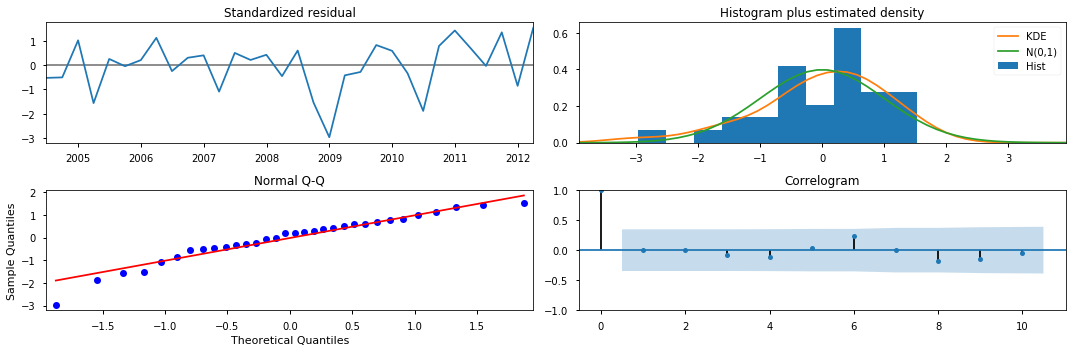

In [14]:
fit_model.plot_diagnostics(figsize=(15,5))
plt.tight_layout()
plt.show()

Looking at the PACF plot for the residuals, we can include 1 seasonal AR term in the model. Other than that residuals are looking not significantly different from White Noise, as claimed by th Ljung-Box statistic and Normal vs KDE plot.

In [15]:
# Fitting a model with revised Seasonality order

revised_model = ARIMA(train_ts, order=(1,1,2), seasonal_order=(2,1,0,4))
fit_revised_model = revised_model.fit() 

print('AIC Value = ',fit_revised_model.aic)
print('Parameters     pValue')
for i in range(len(revised_model.param_names)):
    print(revised_model.param_names[i], '%15.3f' %fit_revised_model.pvalues[i])

AIC Value =  134.86118843950743
Parameters     pValue
ar.L1           0.000
ma.L1           0.004
ma.L2           0.251
ar.S.L4           0.060
ar.S.L8           0.349
sigma2           0.000


- We see that AIC value is greater than previously fitted model. Therefore, we can say that it performs marginally worse than previous model.
- With that, co-efficient for three terms are non-significant. Thus, It is better to resort to *ARIMA(1,1,2)(1,1,0)[4]*

### C) Next task is to forecast for the testing period and validate the forecasts

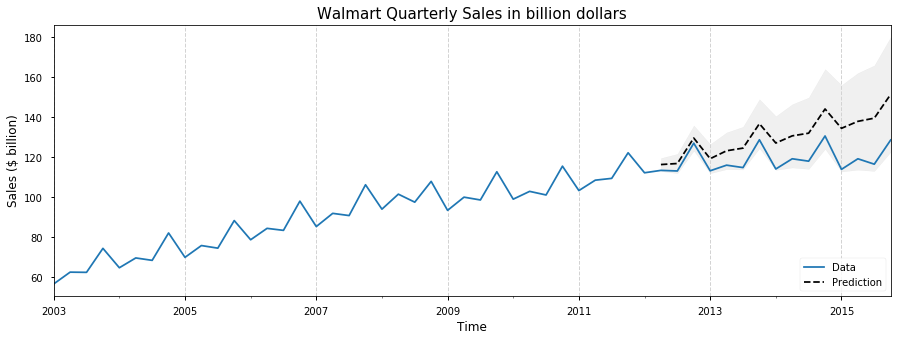

In [16]:
predictions = fit_model.get_forecast(len(test_ts)).summary_frame() # Forecasting for the test period

# Generating a plot for the predicted and original data with Confidence Interval
fig, ax = plt.subplots(figsize=(15, 5))
ts.plot(ax=ax)
predictions['mean'].plot(ax=ax, style='k--')
ax.fill_between(predictions.index, predictions['mean_ci_lower'], predictions['mean_ci_upper'], color='k', alpha=0.06)
ax.legend(('Data','Prediction'), loc='lower right')
plt.grid(b=True,axis='x', linestyle='--',  color='#D3D3D3')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales ($ billion)', fontsize=12)
plt.title('Walmart Quarterly Sales in billion dollars', fontsize = 15)
plt.show()

In [17]:
checker = 0
for period in range(len(predictions)):
    if predictions['mean_ci_lower'][period] <= test_ts['Sales ($ billion)'][period] <= predictions['mean_ci_upper'][period]:
        pass
    else:
        checker += 1
if checker == 0:
    print('All values fall inside the Confidence Interval')

All values fall inside the Confidence Interval


In [18]:
predicted_values = predictions['mean'].to_frame()
predicted_values.columns = ['Sales ($ billion)']

In [19]:
# Calculate the error from the forecast
error = test_ts - predicted_values

# Calculate MAE
print('Mean Absolute Percent Error:', round(np.mean(abs(error/test_ts))[0],4))

# Calculate RMSE
print('Root Mean Squared Error:', np.sqrt(np.mean(error**2)[0]))

Mean Absolute Percent Error: 0.099
Root Mean Squared Error: 13.609889233408621


#### Fitting the Model using Rolling Forecast Origin

In [20]:
rolling_predictions = test_ts.copy()
for period in range(len(test_ts)):
    train_data = ts.iloc[:len(train_ts)+period]
    rolling_model = ARIMA(train_data, order=(1,1,2), seasonal_order=(1,1,0,4))
    rolling_fit = rolling_model.fit()
    prediction = rolling_fit.forecast()
    rolling_predictions.iloc[period]['Sales ($ billion)'] = prediction

In [21]:
rolling_residuals = test_ts - rolling_predictions

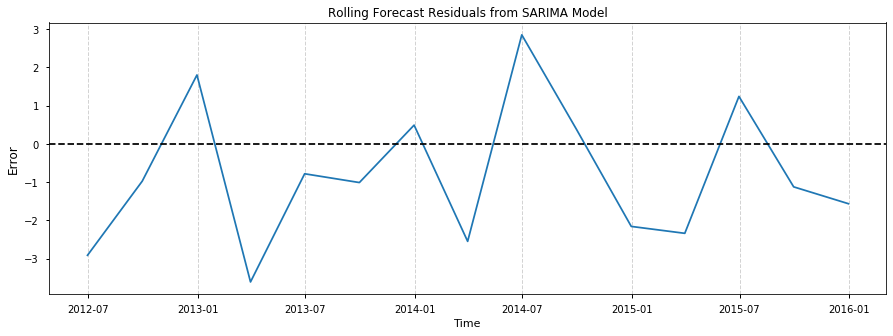

In [22]:
rolling_residuals = test_ts - rolling_predictions
plot_it(rolling_residuals, 'Error')
plt.axhline(0, linestyle='--', color='k')
plt.grid(b=True,axis='x', linestyle='--',  color='#D3D3D3')
plt.title("Rolling Forecast Residuals from SARIMA Model")
plt.show()

In [23]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_ts))[0],4))
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)[0]))

Mean Absolute Percent Error: 0.0145
Root Mean Squared Error: 1.9601084458788562


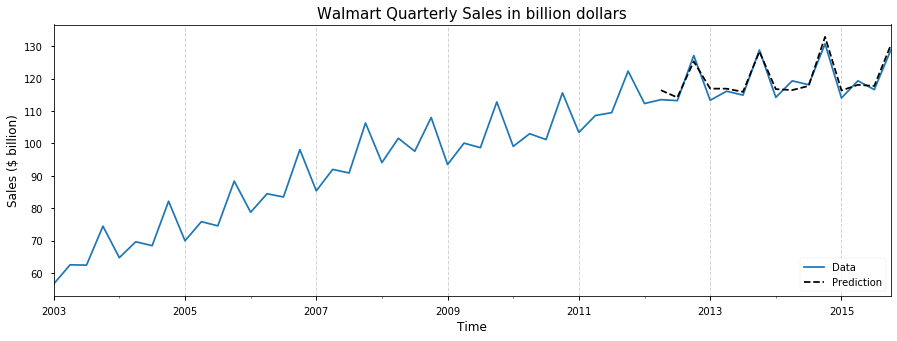

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
ts.plot(ax=ax)
rolling_predictions.plot(ax=ax, style='k--')
ax.legend(('Data','Prediction'), loc='lower right')
plt.ylabel('Sales ($ billion)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.grid(b=True,axis='x', linestyle='--',  color='#D3D3D3')
plt.title('Walmart Quarterly Sales in billion dollars', fontsize = 15)
plt.show()

It is clearly evident that Rolling forecast yielded better results.  

### D) Finally, we will forecast for next 4 quarters.

In [25]:
mdl = ARIMA(ts[:-1],order=(1,1,2),seasonal_order=(1,1,0,4))
fit_mdl = mdl.fit()
predict = fit_mdl.get_forecast(5).summary_frame() # Forecasting period is kept 5 to achieve a continous plot.

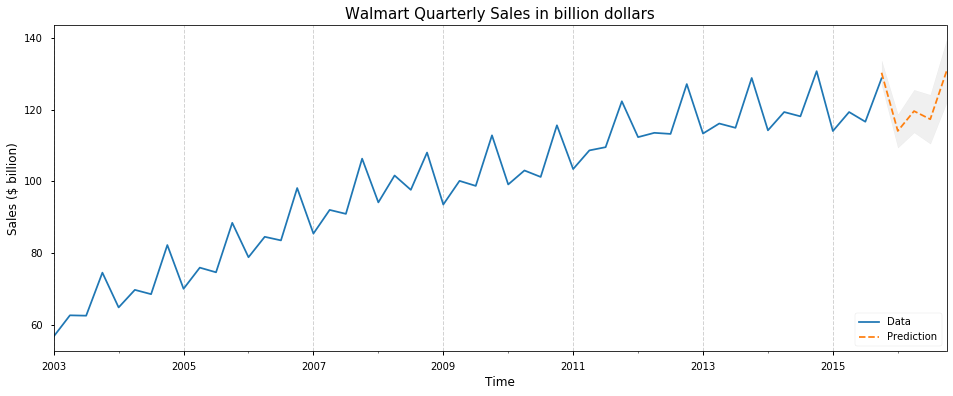

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
ts.plot(ax=ax)
predict['mean'].plot(ax=ax, style='--')
ax.fill_between(predict.index, predict['mean_ci_lower'], predict['mean_ci_upper'], color='k', alpha=0.06)
ax.legend(('Data','Prediction'), loc='lower right')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales ($ billion)', fontsize=12)
plt.grid(b=True,axis='x', linestyle='--',  color='#D3D3D3')
plt.title('Walmart Quarterly Sales in billion dollars', fontsize = 15)
plt.show()

<h3><center><i>THE END</i></center></h3>